In [1]:
import sys
import pandas as pd
import numpy as np
import datetime
import requests
import numpy as np
from pandas import ExcelWriter
import os
import glob
import pytz
from dateutil.tz import gettz
import timeit
import matplotlib.pyplot as plt
# from datetime import datetime
from datetime import timedelta
import time
pd.set_option('display.max_rows', None)

In [2]:
def read_data(devid, acc_token, address, start_time, end_time, descriptors):

    r2 = requests.get(
        url=address + "/api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys=" + descriptors + "&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()

    if r2:
        df = pd.DataFrame([])

        for desc in r2.keys():
            df1 = pd.DataFrame(r2[desc])
            df1.set_index('ts', inplace=True)
            df1.columns = [str(desc)]
            
            df1.reset_index(drop=False, inplace=True)
            df1['ts'] = pd.to_datetime(df1['ts'], unit='ms')
            df1 = df1.sort_values(by=['ts'])
            df1.reset_index(drop=True, inplace=True)
            df1.set_index('ts', inplace=True, drop=True)
            
            for col in df1.columns:
                df1[col] = df1[col].astype('float')
                
            
            df = pd.concat([df, df1], axis=1)


        if df.empty:
            df = pd.DataFrame([])
    else:
        df = pd.DataFrame([])
        print('Empty json!')
    return df


In [128]:
devname = '000.888.000126'
descriptors = 'ppb,tmp,hmd'


# start_time = '1620248400000'
start_time = '1620594000000'
end_time = '1622555537000'


address =  "https://m3.meazon.com"

r = requests.post(address + "/api/auth/login",
                  json={'username': 'a.andrikopoulos19@meazon.com', 'password': 'andrikopMeazon13'}).json()

# acc_token is the token to be used in the next request
acc_token = 'Bearer' + ' ' + r['token']

# get devid by serial name
r1 = requests.get(
    url=address + "/api/tenant/devices?deviceName=" + devname,
    headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()

devid = r1['id']['id']

df = read_data(devid, acc_token, address, start_time, end_time, descriptors)

df = df.resample('1T').mean()
df = df.fillna(method='ffill')
df.loc[df['tmp']<0]= np.nan
df = df.dropna()
df['day'] = df.index.weekday
df['hour'] = df.index.hour
# df = df.loc[df['day']<5]
# df = df.loc[(df['hour']<=15) & (df['hour']>=8)]

df.drop(['day','hour'],axis=1,inplace=True)
df.describe()

,ppb,tmp,hmd
count,32673.000000,32673.000000,32673.000000
mean,298.940899,26.546506,40.940446
std,266.800718,1.330641,4.809983
min,0.000000,24.400000,23.300000
25%,152.000000,25.400000,39.100000
50%,258.000000,26.100000,42.300000
75%,335.000000,28.000000,43.700000
max,3709.000000,29.700000,51.500000


In [129]:
# from sklearn.preprocessing import MinMaxScaler
# min_max_scaler = MinMaxScaler()
# df[['tmp']] = min_max_scaler.fit_transform(df[['tmp']])

In [130]:
devname = '000.888.000133'
descriptors = 'bindc,illu'

# get devid by serial name
r1 = requests.get(
    url=address + "/api/tenant/devices?deviceName=" + devname,
    headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()

devid = r1['id']['id']

df2 = read_data(devid, acc_token, address, start_time, end_time, descriptors)

df2 = df2.resample('1T').max()
df2 = df2.fillna(method='ffill')
df2 = df2.dropna()
df2['day'] = df2.index.weekday
df2['hour'] = df2.index.hour
# df2 = df2.loc[df2['day']<5]
# df2 = df2.loc[(df2['hour']<=15) & (df2['hour']>=8)]

df2.drop(['day','hour'],axis=1,inplace=True)

df2.head()

,bindc,illu
ts,,
2021-05-09 21:09:00,0.0,6473.0
2021-05-09 21:10:00,0.0,6473.0
2021-05-09 21:11:00,0.0,6473.0
2021-05-09 21:12:00,0.0,6473.0
2021-05-09 21:13:00,0.0,6473.0


In [131]:
df = pd.concat([df,df2],axis=1)
df.rename(columns={'bindc':'Motion','illu':'Illuminance','tmp':'Temperature','hmd':'Humidity','ppb':'Air quality'},inplace=True)
df = df.dropna()
df.head()

,Air quality,Temperature,Humidity,Motion,Illuminance
ts,,,,,
2021-05-09 21:09:00,11.0,25.1,35.9,0.0,6473.0
2021-05-09 21:10:00,11.0,25.1,35.9,0.0,6473.0
2021-05-09 21:11:00,11.0,25.1,35.9,0.0,6473.0
2021-05-09 21:12:00,11.0,25.1,35.9,0.0,6473.0
2021-05-09 21:13:00,11.0,25.1,35.9,0.0,6473.0


In [136]:
df = df.resample('1H').agg({'Air quality':np.mean,'Temperature':np.mean,'Humidity':np.mean,'Motion':np.sum,'Illuminance':np.mean})
df = df.dropna()

In [137]:
df.head(15)

,Air quality,Temperature,Humidity,Motion,Illuminance
ts,,,,,
2021-05-09 21:00:00,9.016667,25.038333,35.956667,0.0,6461.550000
2021-05-09 22:00:00,5.566667,24.961667,35.983333,0.0,6460.333333
2021-05-09 23:00:00,8.800000,24.918333,35.983333,0.0,6461.500000
2021-05-10 00:00:00,7.333333,24.856667,35.961667,0.0,6455.000000
2021-05-10 01:00:00,6.100000,24.858333,35.875000,0.0,6454.833333
2021-05-10 02:00:00,3.733333,24.765000,35.725000,0.0,6453.833333
2021-05-10 03:00:00,6.650000,24.725000,35.550000,0.0,9907.816667
2021-05-10 04:00:00,19.233333,24.816667,35.058333,10.0,28985.800000
2021-05-10 05:00:00,172.766667,24.843333,31.590000,51.0,37221.083333


In [138]:
# fig = plt.figure(figsize=[12,8])
# plt.plot(df['bindc'])
# fig = plt.figure(figsize=[12,8])

# plt.plot(df['ppb'])

Text(0.5, 1, 'Correlation heatmap')

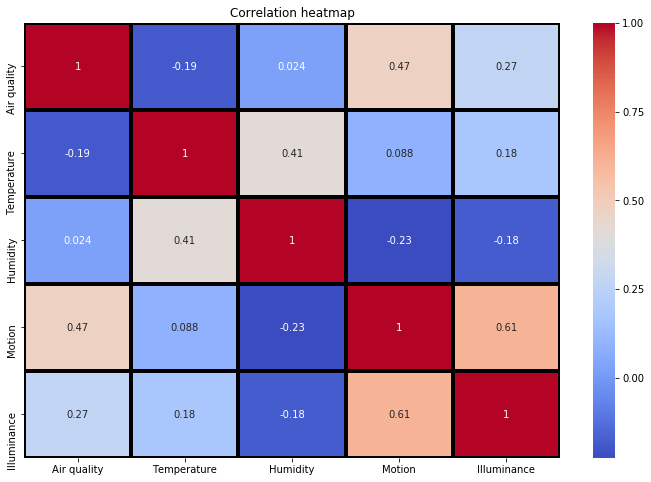

In [139]:
import seaborn as sns
fig = plt.figure(figsize=[12,8])
ax = sns.heatmap(df.corr(), annot = True,cmap= 'coolwarm',linewidths=3, linecolor='black')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Correlation heatmap')


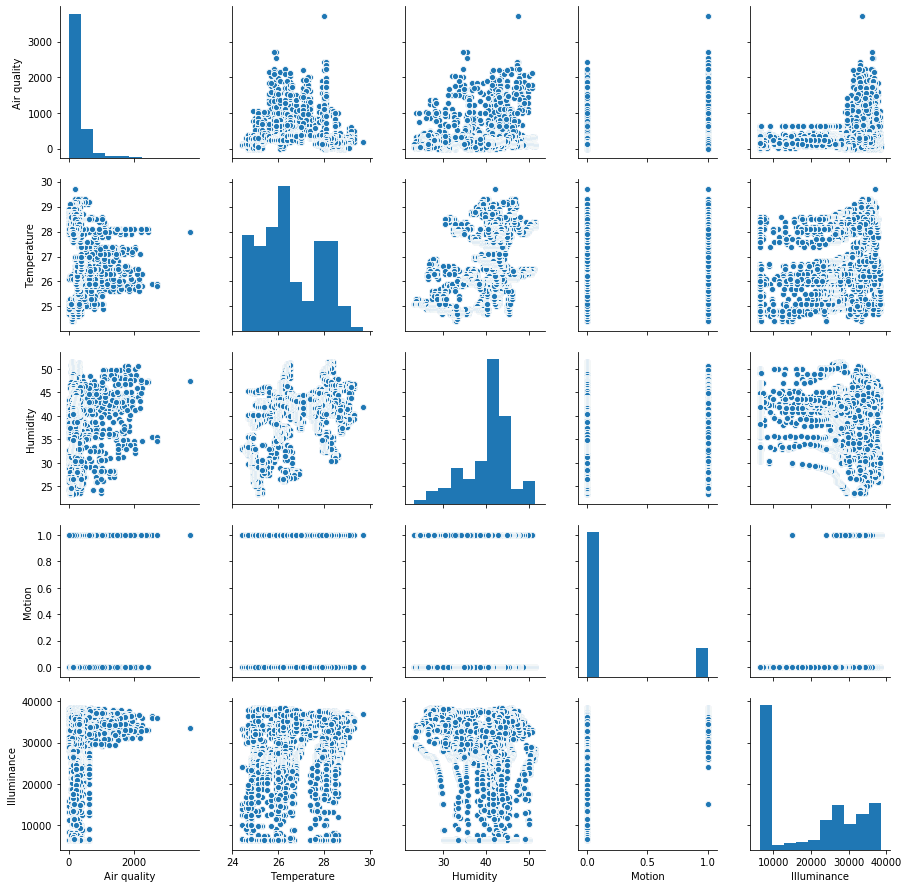

In [69]:
sns.pairplot(df)


In [66]:
from scipy.stats import pearsonr

import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues



In [121]:
# lagged_correlation = pd.DataFrame.from_dict(
#     {x: [df['ppb'].corr(df[x].shift(-t)) for t in range(40)] for x in df.columns})
# lagged_correlation